## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file. <br>
Also import other necessary libraries to be used in this notebook.

In [ ]:
from tcgame_env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
#Define the object from tictcatoe file as env
env= TicTacToe()

In *tcgame_env_final* file, state is defined as a 9 x 1 array. To store it as key of disctionary, we convert it to a '-' separate string. For example, consider the intermediate board position:

x | 4 | 5 <br>
3 | 8 | x <br>
x | x | x 

as an array it is written as = [nan, 4, 5, 3, 8, nan, nan, nan, nan]. To use it as a key for Q - dictionary we rewrite this as 'x-4-5-3-8-x-x-x-x'


In [ ]:
def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [ ]:
# Default state at statrt of any game
Q_state(env.state)

'x-x-x-x-x-x-x-x-x'

Defining a function which will return valid (all possible actions) actions corresponding to a state. Note that, the function action_space() returns both agent action and environment actions. Through this function, we are only storing *agent actions*


In [ ]:
def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] 
    return valid_Actions

In [ ]:
# Default actions for an agent at start of any game
valid_actions(env.state)

[(0, 1),
 (0, 3),
 (0, 5),
 (0, 7),
 (0, 9),
 (1, 1),
 (1, 3),
 (1, 5),
 (1, 7),
 (1, 9),
 (2, 1),
 (2, 3),
 (2, 5),
 (2, 7),
 (2, 9),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 7),
 (3, 9),
 (4, 1),
 (4, 3),
 (4, 5),
 (4, 7),
 (4, 9),
 (5, 1),
 (5, 3),
 (5, 5),
 (5, 7),
 (5, 9),
 (6, 1),
 (6, 3),
 (6, 5),
 (6, 7),
 (6, 9),
 (7, 1),
 (7, 3),
 (7, 5),
 (7, 7),
 (7, 9),
 (8, 1),
 (8, 3),
 (8, 5),
 (8, 7),
 (8, 9)]

If a state is appeared for first time the Q-value for this state should be initialized as 0 in Q-dictionary.

In [ ]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

**Epsilon-greedy strategy** <br>
Take action $a$ , where $ a = argmax_{a} Q(action=a| state=s) $ with probability
$$ 1 - \epsilon + \frac{\epsilon}{|A(s)|} $$ if 

else  take any other action with probability
$$ \frac{\epsilon}{|A(s)|} $$

For large action space $|A(s)|$ , $\frac{\epsilon}{|A(s)|}$ is negligible. <br>
Clearly if $\epsilon$ is small then the policy provides less chance of exploration. On the other hand a large value of $\epsilon$ allows more chance of exploration. We use an additional decay componenet to gradually reduce epsilon over episodes so that out=r policy starts with exploration and as the experience grows , it moves towards a deterministic policy.


In [ ]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, time):

  epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(decay_rate*time)

  x = np.random.random() # draws a random number from 0 to 1

  if x > epsilon:
      state1 = Q_state(state)
      # Exploitation: Use the action that has maximum q value in current q values for the given state
      action = max(Q_dict[state1],key=Q_dict[state1].get)   
  else:
    allowed_action_space = [i for i in env.action_space(state)[0]]
    #Exploration: randomly choosing and action        
    action = allowed_action_space[np.random.choice(range(len(allowed_action_space)))]  
     
  return action 



**Tracking the state-action pairs for checking convergence**

In [ ]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)


Sample satte action pairs to be tracked -
*Note*
We have used states that are most frequently visisted, i.e. states that are likely to be at very begining or after 1 or 2 steps. <br>
Clearly such states will have a lot of 'x' and few numbers. We have selected them purposefully , since such states are most likely to appear that states that are filled up with numbers and less 'x' values. This is easier to achieve (and check) convergence.

In [ ]:
# Initialise states to be tracked
def initialise_tracking_states():
  # 4 possible samples
  sample_action_pairs = [('3-x-x-x-x-x-x-x-8',(4,1)),
                       ('x-5-x-2-x-x-4-7-x',(0,9)),
                       ('x-5-x-2-x-x-4-7-x',(4,3)),
                       ('x-3-x-x-x-6-x-x-x',(2,7)),
                       ('x-x-1-x-x-x-8-x-x',(8,3)),
                       ('x-x-1-x-x-x-8-x-x',(4,3)),
                       ('x-x-x-x-5-x-x-x-6',(0,1)),
                       ('x-x-x-x-5-x-x-x-6',(2,1)),
                       ('x-1-8-x-x-x-x-x-x',(4,9)),
                       ('x-1-8-x-x-x-x-x-x',(4,3)),
                       ('2-7-x-x-6-x-x-3-x',(8,5)),
                       ('9-x-x-x-x-2-x-x-x',(2,5)),
                       ('x-x-7-x-x-x-x-x-2',(1,5)),
                       ('5-x-x-x-x-6-x-x-x',(4,9)),
                       ('4-x-x-6-x-x-3-1-x',(8,5)),
                       ('5-x-8-x-x-6-3-x-x',(3,1)),
                       ('x-6-5-x-2-x-x-3-x',(0,7)),
                       ('7-x-5-x-2-x-x-x-6',(1,3))]
  for q in sample_action_pairs:
    state = q[0]
    action = q[1]
    States_track[state][action] = [] 

save Q dictionary as a pickle file

In [ ]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

save tracking states as pickle file

In [ ]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [ ]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [ ]:

EPISODES= 2000000
LR= 0.1           #Learning rate in Q-learning
GAMMA = 0.8        # Discount factor
decay_rate= -0.0000025

min_epsilon = 0.0001
max_epsilon = 1

threshold = 1000      # no of episodes after which states_tracked will be saved

checkpoint_store = 20000 # store performance after these many episodes
checkpoint_print = 200000 # Print result after this many episodes


### Q-update loop ---write your code here

In [ ]:
import time
start_time = time.time()

agent_win_count = 0
env_win_count = 0
tie_count = 0

agent_win_progress=[]
env_win_progress =[]
tie_progress = []

for episode in tqdm(range(EPISODES)):
  #Start of a new episode 
  reward= 0
  total_reward = 0


  env= TicTacToe()
  state_curr = env.state #Initialize state
  game_result = False    # Initialize result
  add_to_dict(state_curr) # Add initial state to dictionary

  while game_result== False:

    state_curr_qdict_key= Q_state(state_curr) #forming key suitable for q dictionary

    action_curr= epsilon_greedy(state_curr, episode) # select epsilon greedy action from currrent state

    state_updated, reward, game_result, msg = env.step(state_curr, action_curr) # Run a step and update state reward and result

    state_updated_qdict_key= Q_state(state_updated) #forming key suitable for q dictionary for new state

    add_to_dict(state_updated) # Add state to dictionary

    if game_result== False:

      best_action = max(Q_dict[state_updated_qdict_key],key=Q_dict[state_updated_qdict_key].get )
      # update q value using q learning algorithm
      Q_dict[state_curr_qdict_key][action_curr] += LR * (reward + GAMMA*Q_dict[state_updated_qdict_key][best_action] - Q_dict[state_curr_qdict_key][action_curr])
      total_reward += reward
    else:
      Q_dict[state_curr_qdict_key][action_curr] += LR * (reward - Q_dict[state_curr_qdict_key][action_curr])
      total_reward += reward
      # Tracking the count of games won by agent and environment
      if msg == 'Agent wins':
        agent_win_count += 1
      elif msg == 'Env wins':
        env_win_count += 1
      else:
        tie_count += 1

    state_curr = state_updated

  if (episode + 1) % checkpoint_store==0:
    w=agent_win_count / (episode + 1)
    agent_win_progress.append(w)

    l=env_win_count /(episode + 1)
    env_win_progress.append(l)

    t = tie_count / (episode + 1)
    tie_progress.append(t)

  if (episode + 1) % checkpoint_print == 0:
    print(" After %d games, RL Agent wins : %.4f, Environment Wins : %.4f, Tie : %.4f"% (episode + 1, 
        agent_win_count / (episode + 1), env_win_count /(episode + 1), tie_count / (episode + 1)))
    
  #states tracking   
  if ((episode+1)%threshold)==0:
    save_tracking_states()

        

elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracking')   
save_obj(Q_dict,'Policy_Q_dict')


 10%|█         | 200093/2000000 [04:43<39:53, 751.85it/s]

 After 200000 games, RL Agent wins : 0.2556, Environment Wins : 0.2821, Tie : 0.4623


 20%|██        | 400113/2000000 [08:54<28:42, 928.99it/s]

 After 400000 games, RL Agent wins : 0.3009, Environment Wins : 0.2627, Tie : 0.4364


 30%|███       | 600173/2000000 [12:24<22:59, 1014.48it/s]

 After 600000 games, RL Agent wins : 0.3892, Environment Wins : 0.2280, Tie : 0.3828


 40%|████      | 800119/2000000 [15:31<18:31, 1079.14it/s]

 After 800000 games, RL Agent wins : 0.4710, Environment Wins : 0.1955, Tie : 0.3335


 50%|█████     | 1000189/2000000 [18:24<14:17, 1166.43it/s]

 After 1000000 games, RL Agent wins : 0.5386, Environment Wins : 0.1692, Tie : 0.2922


 60%|██████    | 1200254/2000000 [21:08<10:05, 1321.54it/s]

 After 1200000 games, RL Agent wins : 0.5924, Environment Wins : 0.1487, Tie : 0.2589


 70%|███████   | 1400218/2000000 [23:46<07:43, 1294.12it/s]

 After 1400000 games, RL Agent wins : 0.6360, Environment Wins : 0.1326, Tie : 0.2314


 80%|████████  | 1600250/2000000 [26:23<05:10, 1289.27it/s]

 After 1600000 games, RL Agent wins : 0.6713, Environment Wins : 0.1194, Tie : 0.2093


 90%|█████████ | 1800240/2000000 [29:00<02:27, 1352.20it/s]

 After 1800000 games, RL Agent wins : 0.7003, Environment Wins : 0.1084, Tie : 0.1913


100%|██████████| 2000000/2000000 [31:34<00:00, 1055.69it/s]


 After 2000000 games, RL Agent wins : 0.7246, Environment Wins : 0.0994, Tie : 0.1760


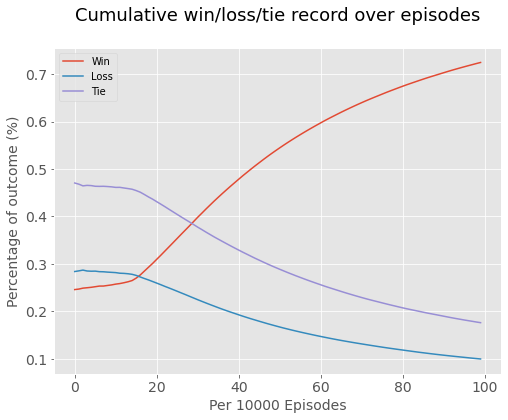

In [ ]:
plt.figure(figsize=(8,6))
# Change style for better visual display
plt.style.use('ggplot')


x=np.arange(0,int(EPISODES/checkpoint_store))
plt.plot(x,agent_win_progress, label="Win")
plt.plot(x, env_win_progress, label ="Loss")
plt.plot(x, tie_progress, label="Tie")
plt.legend()

plt.title("Cumulative win/loss/tie record over episodes\n", size=18)
plt.ylabel("Percentage of outcome (%)", size=14)
plt.xlabel ("Per 10000 Episodes", size=14)
# manage x and y axis tickvalues
# after plotting the data, format the labels
current_values = plt.gca().get_xticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
plt.yticks(size=14)
plt.xticks(size=14)
plt.show()
#len(agent_win_progress)

We have started with a game that is evenly distributed between RL agent and environment. However at end of 1 million simulation using a $\epsilon$-greeey algorithm , along with a Q-learning , RL agent is now 6 times likely to win compared to environment. <br>
It is clear that , still there is a scope to improve policy through further simulation. Due to limitation of resource , we stop the simulation at 1 million.

#### Check the Q-dictionary

In [ ]:
Q_dict['x-1-x-x-x-x-8-x-x']

{(0, 3): -1.0,
 (0, 5): -0.6650343851671,
 (0, 7): -0.6513215599000001,
 (0, 9): 1.5466583266636587,
 (2, 3): -1.1749335599,
 (2, 5): -1.5125795110000002,
 (2, 7): -0.6513215599000001,
 (2, 9): -0.6513215599000001,
 (3, 3): -1.37953279,
 (3, 5): -0.64367412391,
 (3, 7): -0.68618940391,
 (3, 9): -0.7458134171671,
 (4, 3): -0.6513215599000001,
 (4, 5): -1.4405795110000001,
 (4, 7): -0.6125795110000001,
 (4, 9): -0.6525298495024543,
 (5, 3): -0.6125795110000001,
 (5, 5): -0.6125795110000001,
 (5, 7): -0.6513215599000001,
 (5, 9): -0.6513215599000001,
 (7, 3): -0.6125795110000001,
 (7, 5): -0.6125795110000001,
 (7, 7): -0.6703312635190002,
 (7, 9): -0.5792504635190001,
 (8, 3): -0.6125795110000001,
 (8, 5): -1.2507031000000002,
 (8, 7): -0.617843263519,
 (8, 9): -0.68618940391}

In [ ]:
len(Q_dict)

1017068

#### Check the states tracked for Q-values convergence


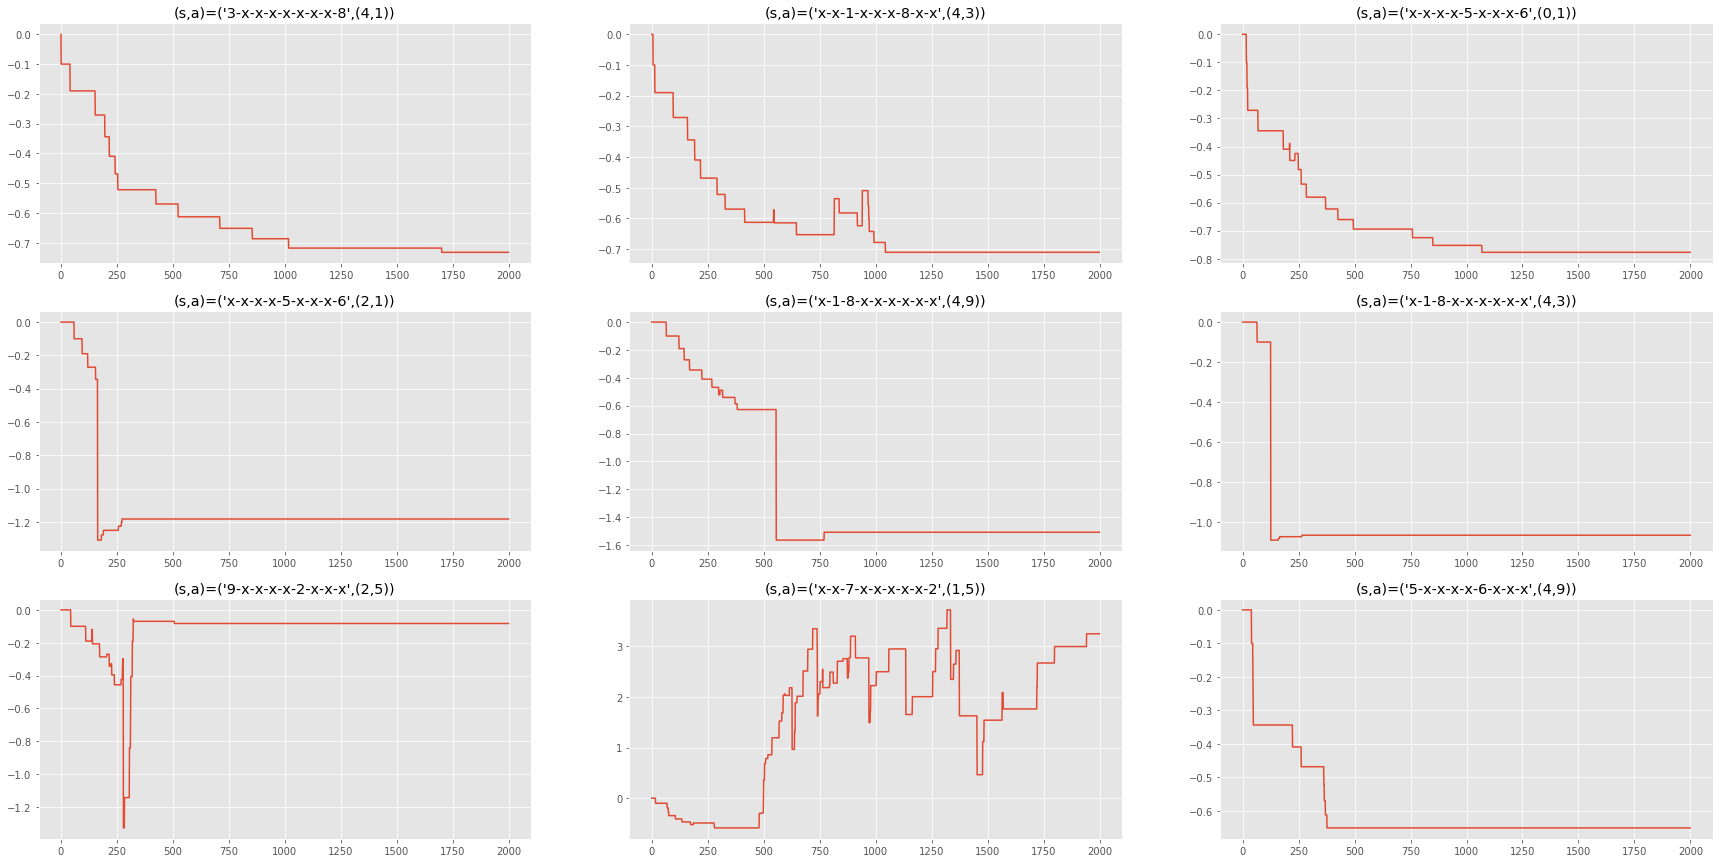

In [ ]:
plt.figure(0, figsize=(30,15))
plt.subplot(3,3,1)
t1=States_track['3-x-x-x-x-x-x-x-8'][(4,1)]
plt.title("(s,a)=('3-x-x-x-x-x-x-x-8',(4,1))")
plt.plot(np.asarray(range(0, len(t1))),np.asarray(t1))


plt.subplot(3, 3, 2)
t6=States_track['x-x-1-x-x-x-8-x-x'][(4,3)]
plt.title("(s,a)=('x-x-1-x-x-x-8-x-x',(4,3))")
plt.plot(np.asarray(range(0, len(t6))),np.asarray(t6))

plt.subplot(3, 3, 3)
t7=States_track['x-x-x-x-5-x-x-x-6'][(0,1)]
plt.title("(s,a)=('x-x-x-x-5-x-x-x-6',(0,1))")
plt.plot(np.asarray(range(0, len(t7))),np.asarray(t7))

plt.subplot(3, 3, 4)
t8=States_track['x-x-x-x-5-x-x-x-6'][(2,1)]
plt.title("(s,a)=('x-x-x-x-5-x-x-x-6',(2,1))")
plt.plot(np.asarray(range(0, len(t8))),np.asarray(t8))

plt.subplot(3, 3, 5)
t9=States_track['x-1-8-x-x-x-x-x-x'][(4,9)]
plt.title("(s,a)=('x-1-8-x-x-x-x-x-x',(4,9))")
plt.plot(np.asarray(range(0, len(t9))),np.asarray(t9))

plt.subplot(3, 3, 6)
t10=States_track['x-1-8-x-x-x-x-x-x'][(4,3)]
plt.title("(s,a)=('x-1-8-x-x-x-x-x-x',(4,3))")
plt.plot(np.asarray(range(0, len(t10))),np.asarray(t10))


plt.subplot(3, 3, 7)
t12=States_track['9-x-x-x-x-2-x-x-x'][(2,5)]
plt.title("(s,a)=('9-x-x-x-x-2-x-x-x',(2,5))")
plt.plot(np.asarray(range(0, len(t12))),np.asarray(t12))

plt.subplot(3, 3, 8)
t13=States_track['x-x-7-x-x-x-x-x-2'][(1,5)]
plt.title("(s,a)=('x-x-7-x-x-x-x-x-2',(1,5))")
plt.plot(np.asarray(range(0, len(t13))),np.asarray(t13))


plt.subplot(3, 3, 9)
t14=States_track['5-x-x-x-x-6-x-x-x'][(4,9)]
plt.title("(s,a)=('5-x-x-x-x-6-x-x-x',(4,9))")
plt.plot(np.asarray(range(0, len(t14))),np.asarray(t14))


plt.show()

### Epsilon - decay check

In [ ]:
time= np.arange(0, EPISODES)
e=[]

for t in time:
  epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(decay_rate*t)
  e.append(epsilon)

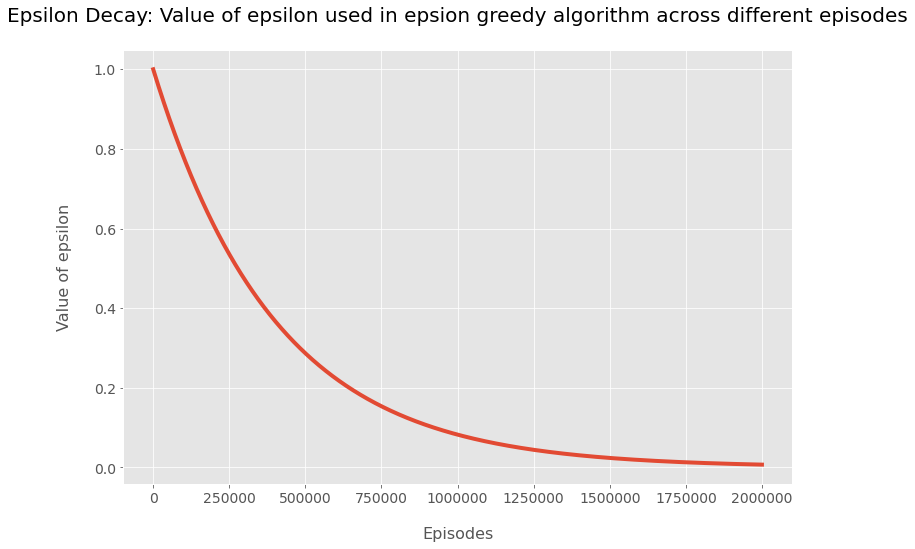

In [ ]:
plt.figure(figsize=(12, 8))
# Change style for better visual display
plt.style.use('ggplot')

plt.plot(time, e, linewidth=4)
# Axis title
plt.title("Epsilon Decay: Value of epsilon used in epsion greedy algorithm across different episodes\n", size=20)
plt.xlabel("\nEpisodes", size =16)
plt.ylabel("Value of epsilon\n", size=16)

# manage x and y axis tickvalues
# after plotting the data, format the labels
current_values = plt.gca().get_xticks()
# using format string '{:.0f}' here but you can choose others
plt.gca().set_xticklabels(['{:.0f}'.format(x) for x in current_values])
plt.yticks(size=14)
plt.xticks(size=14)

plt.show()

**Create a sub dictionary with tracked state action pairs (For Submission)**

In [ ]:
keys_to_extract =['3-x-x-x-x-x-x-x-8', 'x-5-x-2-x-x-4-7-x','x-3-x-x-x-6-x-x-x',
                  'x-x-1-x-x-x-8-x-x','x-x-x-x-5-x-x-x-6', 'x-1-8-x-x-x-x-x-x',
                  '2-7-x-x-6-x-x-3-x', '9-x-x-x-x-2-x-x-x', 'x-x-7-x-x-x-x-x-2',
                  '5-x-x-x-x-6-x-x-x', '4-x-x-6-x-x-3-1-x', '5-x-8-x-x-6-3-x-x',
                  'x-6-5-x-2-x-x-3-x', '7-x-5-x-2-x-x-x-6']

Q_dict_tracked = {key: Q_dict[key] for key in keys_to_extract}

save_obj(Q_dict_tracked,'Q_dict_tracked')